# Продвинутое машинное обучение: 
# Домашнее задание 2

Второе задание — это полноценный проект по анализу данных, начиная от анализа постановки задачи и заканчивая сравнением результатов разных моделей. Задача реальная и серьёзная, хотя тему я выбрал развлекательную: мы будем строить вероятностную рейтинг-систему для спортивного “Что? Где? Когда?” (ЧГК).
Background: в спортивном “Что? Где? Когда?” соревнующиеся команды отвечают на одни и те же вопросы. После минуты обсуждения команды записывают и сдают свои ответы на карточках; побеждает тот, кто ответил на большее число вопросов. Турнир обычно состоит из нескольких десятков вопросов (обычно 36 или 45, иногда 60, больше редко). Часто бывают синхронные турниры, когда на одни и те же вопросы отвечают команды на сотнях игровых площадок по всему миру, т.е. в одном турнире могут играть сотни, а то и тысячи команд. Соответственно, нам нужно:
- построить рейтинг-лист, который способен нетривиально предсказывать результаты будущих турниров;
- при этом, поскольку ЧГК — это хобби, и контрактов тут никаких нет, игроки постоянно переходят из команды в команду, сильный игрок может на один турнир сесть поиграть за другую команду и т.д.; поэтому единицей рейтинг-листа должна быть не команда, а отдельный игрок;
- а что сильно упрощает задачу и переводит её в область домашних заданий на EM-алгоритм — это характер данных: начиная с какого-то момента, в базу результатов начали вносить все повопросные результаты команд, т.е. в данных будут записи вида “какая команда на какой вопрос правильно ответила”.



1. Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
- взять в тренировочный набор турниры с dateStart из 2019 года; 
- в тестовый — турниры с dateStart из 2020 года.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
from time import time

import numpy as np
import scipy as sp
import pandas as pd
import zipfile
import requests

from urllib.parse import quote

from scipy.optimize import fmin_powell
from scipy.sparse import coo_matrix
from sklearn.metrics import log_loss
from scipy import integrate
from scipy import linalg
from scipy.stats import kendalltau, spearmanr
from scipy.special import logit, expit

from sklearn.preprocessing import normalize
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

np.set_printoptions(precision=4, suppress=True)

from collections import Counter, defaultdict
from Levenshtein import distance as levenshtein_distance

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

#### Нужно скачать архив с данной страницы и положить рядом с файлом, ссылка: https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip 

In [2]:
import json, pickle

zip_chgk = zipfile.ZipFile('chgk.zip')
# загружаем данные турниров
tournaments = pickle.load(zip_chgk.open('tournaments.pkl'))
# загружаем данные результатов
results = pickle.load(zip_chgk.open('results.pkl'))
# загружаем данные игроков
players = pickle.load(zip_chgk.open('players.pkl'))

In [3]:
print(f"Размер данных турниров: {len(tournaments)}, размер данных результатов: {len(results)}")

Размер данных турниров: 5528, размер данных результатов: 5528


In [4]:
def data_selection(tournaments, results, flag=False):
    """Функция для формирования отбора выборки."""
    
    results_selection = defaultdict(list)

    for k, v in results.items():
        if flag:
            if tournaments[k]["dateStart"][:4] == '2019' or tournaments[k]["dateStart"][:4] == '2020':
                for res in v:
                    if res.get("mask", None) and res.get("teamMembers", []):
                        results_selection[k].append(res)
        else:
            for res in v:
                if res.get("mask", None) and res.get("teamMembers", []):
                    results_selection[k].append(res)

    tournaments_selection = {k: tournaments[k] for k, v in results_selection.items()}
    
    return results_selection, tournaments_selection

In [5]:
# обновляем результаты турниров и сами результаты
results_all, tournaments_val = data_selection(tournaments, results, flag=True)

In [6]:
def train_test_split(results, tournaments):
    """Функция для train, test."""
    
    data_train, data_test = {}, {}
    
    for k, v in results.items():
        # формирование train
        if tournaments[k]["dateStart"][:4] == '2019':
            data_train[k] = {"tournament_name": tournaments[k]["name"]}
            res = []
            for turn in v:
                team_info = {"team_id": turn["team"]["id"], "mask": turn["mask"],
                             "position": turn["position"],
                             "teamMembers": [iterr["player"]["id"] for iterr in turn['teamMembers']]}
                res.append(team_info)
            data_train[k]["tournament_result"] = res
        else:
            # формирование test
            data_test[k] = {"tournament_name": tournaments[k]["name"]}
            res = []
            for turn in v:
                team_info = {"team_id": turn["team"]["id"], "mask": turn["mask"],
                             "position": turn["position"],
                             "teamMembers": [iterr["player"]["id"] for iterr in turn['teamMembers']]}
                res.append(team_info)
            data_test[k]["tournament_result"] = res
        
    return data_train, data_test

In [7]:
# формируем выборку для train и test
data_train, data_test = train_test_split(results_all, tournaments_val)

2. Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
- повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
- в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
- для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.

In [8]:
def check_count_players(dataset):
    """Считаем количество игроков, участвующих в турнире."""
    
    players = Counter()
    for val in dataset.values():
        for team in val["tournament_result"]:
            players += Counter({iterr: 1 for iterr in team["teamMembers"]})
            
    return players


def filter_value(count_players):
    """Отбрасываем игроков, которые сыграли меньше 1 турнира."""
    
    players_inteval = set()
    for k, v in count_players.most_common():
        if v <= 1:
            players_inteval.add(k)
            
    return players_inteval


# фильтрация игроков
count_players = check_count_players(data_train)
filter_value_players = filter_value(count_players)
    
del_players = set()
for res in data_train.values():
    for tourn in res["tournament_result"]:
        tourn["teamMembers"] = set([-1 if iterr in filter_value_players else iterr for iterr in tourn["teamMembers"]])
        del_players.update(tourn["teamMembers"])

for res in data_test.values():
    for tourn in res["tournament_result"]:
        tourn["teamMembers"] = set([-1 if iterr not in del_players else iterr for iterr in tourn["teamMembers"]])  

In [9]:
def features_data(dataset):
    """Обработка вопросов."""

    questions = set()
    for k, v in dataset.items():
        for team in v["tournament_result"]:
            questions.update(team["teamMembers"])
            questions_ids = (f"{k}_{iterr}" for iterr in range(len(team["mask"])))
            questions.update(questions_ids)
    questions = {v: i for i, v in enumerate(questions)}
        
    return questions

In [10]:
# обработка вопросов
questions_data = features_data(data_train)

In [11]:
def to_assray(value):
    """Преобразование в массив."""
    
    return np.asarray(value, dtype=np.int32)

In [12]:
def data_to_split(dataset, questions_data, flag):
    """Функция для сбора данных вместе."""
    
    val_current, question, label = [], [], []
    number = 0
    for k, v in dataset.items():
        for team in v["tournament_result"]:
            for mask_num, mask in enumerate(team["mask"]):
                try:
                    label.extend([int(mask)] * len(team["teamMembers"]))
                except:
                    continue
                for team_member in team["teamMembers"]:
                    val_current.append(number)
                    question.append(questions_data[team_member])
                    if flag:    
                        val_current.append(number)
                        question.append(questions_data[f"{k}_{mask_num}"])
                    number += 1

    label = np.asarray(label, dtype=np.int8)
    x = coo_matrix((np.ones(len(val_current)), (to_assray(val_current), to_assray(question))),
                   shape=(len(label), len(questions_data)))
    data_x = pd.DataFrame.sparse.from_spmatrix(x)
    
    return data_x, label

In [13]:
# данные для обучения
X_train, y_train = data_to_split(data_train, questions_data, True)
# данные для теста
X_test, y_test = data_to_split(data_test, questions_data, False)

# обучаем baseline модель
model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

# сделаем предикт на данных и выведем результаты по метрикам
pred_train = model.predict_proba(X_train)
pred_test = model.predict_proba(X_test)
print(f"Результаты для train: {log_loss(y_train, pred_train)}, результаты для test: {log_loss(y_test, pred_test)}")

Результаты для train: 0.4942828679012039, результаты для test: 0.7020491690503211


3. Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
- предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
- в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров

##### Идея: Предалагется отсортировать команды в зависимости от правильности ответов игроков на вопросы, при условии, что хотя бы один игрок отвечает на вопрос верно.

In [14]:
def data_concept(dataset):
    """Инициализируем набор данных с местами команд."""
    
    tournament_id, team_id, pos, answer, tournament_num, team_num, player_num, question_num = [], [], [], [], [], [], [], []
    for k, v in dataset.items():
        for res in v["tournament_result"]:
            tournament_id.append(k)
            team_id.append(res["team_id"])
            pos.append(res["position"])
            for num_mask, mask in enumerate(res["mask"]):
                try:
                    answer.extend([int(mask)] * len(res["teamMembers"]))
                    tournament_num.extend([k] * len(res["teamMembers"]))
                    team_num.extend([res["team_id"]] * len(res["teamMembers"]))
                    question_num.extend([num_mask] * len(res["teamMembers"]))
                except:
                    continue
                for team_member in res["teamMembers"]:
                    player_num.append(team_member)

    data_positions = pd.DataFrame({'tournament_id' : tournament_id, "team_id" : team_id, "position" : pos})
    
    return data_positions, to_assray(tournament_num), to_assray(team_num), to_assray(answer), to_assray(team_id), to_assray(player_num), to_assray(question_num)

# создаем набор данных
data_positions, tournament_num_test, team_num_test, _, _, player_num_test, question_num_test = data_concept(data_test)

In [15]:
def calculate_coeff(dataset, tournament, team, predict_data):
    """Считаем корреляции Спирмена и Кендалла."""
    
    # делаем датафрейм с предсказанными значениями
    data_positions_predict = pd.DataFrame({'tournament_id' : tournament, "team_id" : team, "predict" : 1 - predict_data})
    data_positions_predict = data_positions_predict.groupby(["tournament_id", "team_id"]).agg("prod").reset_index()
    data_positions_predict["position_pred"] = data_positions_predict.groupby("tournament_id")["predict"].rank("dense")
    
    # объединяем данные
    data_merge = data_positions_predict.merge(dataset, on=["tournament_id", "team_id"])
    # инициализируем списки для записи значений
    coeff_kendall, coeff_spearman = [], []
    for iterr in data_merge['tournament_id'].unique():
        val = data_merge.loc[data_merge['tournament_id'] == iterr].position_pred
        val_pred = data_merge.loc[data_merge['tournament_id'] == iterr].position
        # вычисляем значения
        coeff_kendall += [kendalltau(val_pred, val).correlation]
        coeff_spearman += [spearmanr(val_pred, val).correlation]

    # заполяняем значения
    coeff_kendall = np.asarray(coeff_kendall)
    coeff_spearman = np.asarray(coeff_spearman)
    coeff_kendall[np.isnan(coeff_kendall)] = 0.0
    coeff_spearman[np.isnan(coeff_spearman)] = 0.0
    
    return np.mean(coeff_spearman), np.mean(coeff_kendall)

In [16]:
val_coeff_spearman, val_coeff_kendall = calculate_coeff(data_positions, tournament_num_test, team_num_test, pred_test[:, 1])
print(f"Ранговые корреляции Спирмена = {val_coeff_spearman} и Кендалла = {val_coeff_kendall}")

Ранговые корреляции Спирмена = 0.77358015666529 и Кендалла = 0.6190926272413736


4. Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
- предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
- разработайте EM-схему для обучения этой модели, реализуйте её в коде;
- обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


##### Идея: на шаге Е оценивается математическое ожидание ответов игроков - z, а Z - ответ игрока при условии ответа команды. На шаге М оценивается ответ игроков по сложности вопроса, при условии z

In [17]:
# берем набор данных с играми, командами и игроками
_, tournament_num_train, team_num_train, _, _, player_num_train, question_num_train = data_concept(data_train)

In [18]:
def EM_algo(data_positions, X_train, X_test, y_train, tournament_num, team_num, player, question, predict_data, tournament_num_test, team_num_test, iteration):
    """EM - алгоритм."""
    
    for iterr in range(1, iteration):
        # E-шаг
        # делаем датафрейм с предсказанными значениями
        data_em = pd.DataFrame({'tournament_id' : tournament_num, "team_id" : team_num,
                                               'player_id' : player, "questions" : question,
                                               "predict" : predict_data[:, 1]})
        data_em['iverse_predict'] = 1 - data_em["predict"]
        data_pred_teams = data_em.drop(["player_id", "predict"], axis=1).groupby(["tournament_id", "team_id", "questions"]).agg("prod").reset_index()
        data_pred_teams["team_predict"] = 1 - data_pred_teams["iverse_predict"]

        data_em = data_em.drop("iverse_predict", axis=1).merge(data_pred_teams.drop("iverse_predict", axis=1), on=["tournament_id", "team_id", "questions"])
        data_em["z_value"] = data_em["predict"] / data_em["team_predict"]

        z_value = np.where(y_train == 0, 0, data_em["z_value"].values)
        z_value = np.clip(z_value, 1e-6, 1 - 1e-6)

        # M-шаг
        model = linear_model.Ridge(alpha=iterr)
        model.fit(X_train, logit(z_value))
        pred_train_em = expit(model.predict(X_train))
        pred_test_em = expit(model.predict(X_test))

        # оценка по метрикам
        val_coeff_spearman, val_coeff_kendall = calculate_coeff(data_positions, tournament_num_test, team_num_test, pred_test_em)

        print(f"На {iterr} шаге ранговые корреляции Спирмена = {val_coeff_spearman} и корреляция Кендалла: {val_coeff_kendall}\n")
        
    return pred_test_em, model 
# обучение        
pred_test_em, model = EM_algo(data_positions, X_train, X_test, y_train, tournament_num_train,
                              team_num_train, player_num_train, question_num_train, pred_train,
                              tournament_num_test, team_num_test, 11)

На 1 шаге ранговые корреляции Спирмена = 0.7934489970116114 и корреляция Кендалла: 0.6373592366981913

На 2 шаге ранговые корреляции Спирмена = 0.7932310922680609 и корреляция Кендалла: 0.6371797666233624

На 3 шаге ранговые корреляции Спирмена = 0.7939141908301062 и корреляция Кендалла: 0.6374986787389174

На 4 шаге ранговые корреляции Спирмена = 0.793677857202997 и корреляция Кендалла: 0.6372956273321356

На 5 шаге ранговые корреляции Спирмена = 0.7937393300342229 и корреляция Кендалла: 0.6372203570361646

На 6 шаге ранговые корреляции Спирмена = 0.7932117716600684 и корреляция Кендалла: 0.6368038279270962

На 7 шаге ранговые корреляции Спирмена = 0.7930416837030412 и корреляция Кендалла: 0.6367748642762452

На 8 шаге ранговые корреляции Спирмена = 0.7923377179731143 и корреляция Кендалла: 0.6361745072108295

На 9 шаге ранговые корреляции Спирмена = 0.7920534180487692 и корреляция Кендалла: 0.6358359680081481

На 10 шаге ранговые корреляции Спирмена = 0.7919634262934486 и корреляция 

5. А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).

In [19]:
# формируем словарь рейтинга
dict_data_rating = {}
for k, v in tournaments_val.items():
    check = False
    if v['dateStart'][:4] in ['2019', '2020']:
        result_tour = results_all[k]
        val_question = 0
        for q in v['questionQty'].values():
            val_question += q

        for res in result_tour:
            if ('mask' not in res or res['mask'] is None) or ('teamMembers' not in res or res['teamMembers'] is None) or len(res['mask']) != val_question:
                check = True
                break
        if not check and len(result_tour) != 0:
            dict_data_rating[k] = v
# формируем словарь
result_all = {k: results_all[k] for k in dict_data_rating.keys()}

In [20]:
# считаем “рейтинг-лист” турниров по сложности вопросов
# создаем списки для записи id, названия турниров и их рейтинга
id_list, name_list, rating_list = [], [], [] 
for k, v in result_all.items():
    rating_val = [0 for _ in range(len(v[0]['mask']))]
    for team in v:
        for pos in range(len(team['mask'])):
            rating_val[pos] += 1 if team['mask'][pos] == '1' else 0
    tour_rating = np.sum(np.array(rating_val) / len(v))
    id_list.append(k)
    name_list.append(tournaments_val[k]['name'])
    rating_list.append(tour_rating)
    
# создаем датафрейм турниров
data_tournaments = pd.DataFrame({'id': id_list, 'name_tournament': name_list, 'rating': rating_list})
# сортируем данные турниров
data_tournaments = data_tournaments.sort_values(by='rating', ascending=False)

In [21]:
data_tournaments

,id,name_tournament,rating
490,5827,Шестой киевский марафон. Асинхрон,314.750000
124,5405,Кавалькада волхвов,165.200000
766,6212,Кавалькада волхвов,153.454545
389,5709,Высшая лига ЧТ,92.000000
728,6150,Чемпионат Санкт-Петербурга. Высшая лига,80.000000
...,...,...,...
733,6162,33,6.888889
369,5684,Синхрон высшей лиги Москвы,6.600000
633,5998,Memento memes IV,6.573333
394,5717,Чемпионат Таджикистана,4.076923


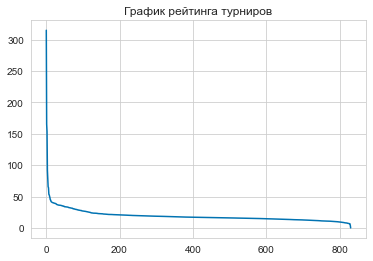

In [22]:
# посмотрим на график урейтинга команд, где видно, что в основном мало топовых турниров, а среднее значение рейтинга составляет 20
plt.plot(range(data_tournaments.rating.shape[0]), data_tournaments.rating.values)
plt.title("График рейтинга турниров")
plt.show()

In [23]:
# выведем топ 10 турниров по сложным вопросам
number = 1
print("Топ 10 турниров по сложным вопросам:\n")
for index, row in data_tournaments[:10].iterrows():
    rating_row = row.copy()
    # выводим значения
    print(f"{number}. {rating_row.name_tournament} {'https://db.chgk.info/search/questions/' + quote(rating_row.name_tournament)}")
    number += 1

Топ 10 турниров по сложным вопросам:

1. Шестой киевский марафон. Асинхрон https://db.chgk.info/search/questions/%D0%A8%D0%B5%D1%81%D1%82%D0%BE%D0%B9%20%D0%BA%D0%B8%D0%B5%D0%B2%D1%81%D0%BA%D0%B8%D0%B9%20%D0%BC%D0%B0%D1%80%D0%B0%D1%84%D0%BE%D0%BD.%20%D0%90%D1%81%D0%B8%D0%BD%D1%85%D1%80%D0%BE%D0%BD
2. Кавалькада волхвов https://db.chgk.info/search/questions/%D0%9A%D0%B0%D0%B2%D0%B0%D0%BB%D1%8C%D0%BA%D0%B0%D0%B4%D0%B0%20%D0%B2%D0%BE%D0%BB%D1%85%D0%B2%D0%BE%D0%B2
3. Кавалькада волхвов https://db.chgk.info/search/questions/%D0%9A%D0%B0%D0%B2%D0%B0%D0%BB%D1%8C%D0%BA%D0%B0%D0%B4%D0%B0%20%D0%B2%D0%BE%D0%BB%D1%85%D0%B2%D0%BE%D0%B2
4. Высшая лига ЧТ https://db.chgk.info/search/questions/%D0%92%D1%8B%D1%81%D1%88%D0%B0%D1%8F%20%D0%BB%D0%B8%D0%B3%D0%B0%20%D0%A7%D0%A2
5. Чемпионат Санкт-Петербурга. Высшая лига https://db.chgk.info/search/questions/%D0%A7%D0%B5%D0%BC%D0%BF%D0%B8%D0%BE%D0%BD%D0%B0%D1%82%20%D0%A1%D0%B0%D0%BD%D0%BA%D1%82-%D0%9F%D0%B5%D1%82%D0%B5%D1%80%D0%B1%D1%83%D1%80%D0%B3%D0%B0.%20%D

In [24]:
# выведем топ 10 турниров по простым вопросам
number = 1
print("Топ 10 турниров по простым вопросам:\n")
for index, row in data_tournaments[-10::].iterrows():
    rating_row = row.copy()
    # выводим значения
    print(f"{number}. {rating_row.name_tournament} {'https://db.chgk.info/search/questions/' + quote(rating_row.name_tournament)}")
    number += 1

Топ 10 турниров по простым вопросам:

1. Открытый кубок МВУТ https://db.chgk.info/search/questions/%D0%9E%D1%82%D0%BA%D1%80%D1%8B%D1%82%D1%8B%D0%B9%20%D0%BA%D1%83%D0%B1%D0%BE%D0%BA%20%D0%9C%D0%92%D0%A3%D0%A2
2. Зеркало Окского марафона. Злой https://db.chgk.info/search/questions/%D0%97%D0%B5%D1%80%D0%BA%D0%B0%D0%BB%D0%BE%20%D0%9E%D0%BA%D1%81%D0%BA%D0%BE%D0%B3%D0%BE%20%D0%BC%D0%B0%D1%80%D0%B0%D1%84%D0%BE%D0%BD%D0%B0.%20%D0%97%D0%BB%D0%BE%D0%B9
3. Чемпионат Кыргызстана https://db.chgk.info/search/questions/%D0%A7%D0%B5%D0%BC%D0%BF%D0%B8%D0%BE%D0%BD%D0%B0%D1%82%20%D0%9A%D1%8B%D1%80%D0%B3%D1%8B%D0%B7%D1%81%D1%82%D0%B0%D0%BD%D0%B0
4. VERSUS: Немец vs. Шагал https://db.chgk.info/search/questions/VERSUS%3A%20%D0%9D%D0%B5%D0%BC%D0%B5%D1%86%20vs.%20%D0%A8%D0%B0%D0%B3%D0%B0%D0%BB
5. Чемпионат школы №1568 https://db.chgk.info/search/questions/%D0%A7%D0%B5%D0%BC%D0%BF%D0%B8%D0%BE%D0%BD%D0%B0%D1%82%20%D1%88%D0%BA%D0%BE%D0%BB%D1%8B%20%E2%84%961568
6. 33 https://db.chgk.info/search/questions/33
7. Си

В целом, "рейтинг-лист" соответствует интуиции, видно, что на турнирах для школьников в основном простые вопросы, а в высших лигах и студенческих чемпионатов - сложные.

6. Бонус: постройте топ игроков по предсказанной вашей моделью силе игры, а рядом с именами игроков напишите общее число вопросов, которое они сыграли. Скорее всего, вы увидите, что топ занят игроками, которые сыграли совсем мало вопросов, около 100 или даже меньше; если вы поищете их в официальном рейтинге ЧГК, вы увидите, что это какие-то непонятные ноунеймы. В baseline-модели, скорее всего, такой эффект будет гораздо слабее.
Это естественное свойство модели: за счёт EM-схемы влияние 1-2 удачно сыгранных турниров будет только усиливаться, потому что неудачных турниров, чтобы его компенсировать, у этих игроков нет. Более того, это не мешает метрикам качества, потому что если эти игроки сыграли всего 1-2 турнира в 2019-м, скорее всего они ничего или очень мало сыграли и в 2020, и их рейтинги никак не влияют на качество тестовых предсказаний. Но для реального рейтинга такое свойство, конечно, было бы крайне нежелательным. Давайте попробуем его исправить:
- сначала жёстко: выберите разумную отсечку по числу вопросов, учитывая, что в одном турнире их обычно 30-50;
- можно ли просто выбросить игроков, которые мало играли, и переобучить модель? почему? предложите, как нужно изменить модель, чтобы не учитывать слишком мало сыгравших, и переобучите модель;
- но всё-таки это не слишком хорошее решение: если выбрать маленькую отсечку, будут ноунеймы в топе, а если большую, то получится, что у нового игрока слишком долго не будет рейтинга; скорее всего, никакой “золотой середины” тут не получится;
- предложите более концептуальное решение для топа игроков в рейтинг-листе; если получится, реализуйте его на практике (за это уж точно будут серьёзные бонусные баллы).


In [25]:
data_players_test = pd.DataFrame({'tournament_id': tournament_num_test, 'team_id': team_num_test,
                                  'player_id': player_num_test, 'questions': question_num_test, 'predict': pred_test_em})
data_players_test["iverse_predict"] = 1 - data_players_test["predict"]

# формируем данные id и предсказанный рейтинг
data_players_test_pred = data_players_test[["player_id", 'predict']].groupby(["player_id"]).agg("mean").reset_index()
data_players_test_question = data_players_test[["player_id", 'questions']].groupby(["player_id"]).agg("count").reset_index()
data_all = data_players_test_pred.merge(data_players_test_question, on=["player_id"])
# формируем данные по играм
data_players_test_tour = data_players_test[["player_id", 'tournament_id']].drop_duplicates().reset_index()
data_players_test_tour = data_players_test_tour.drop("index", axis=1).groupby(["player_id"]).agg("count").reset_index()
# собираем данные вместе
data_all = data_all.merge(data_players_test_tour, on=["player_id"])
data_all = data_all.sort_values(by='predict', ascending=False)
# выведем получившиеся значения
data_all

,player_id,predict,questions,tournament_id
2526,27403,6.316987e-01,517,13
388,4270,5.231739e-01,433,11
2653,28751,5.110516e-01,626,16
2100,22474,4.574046e-01,36,1
2782,30152,4.459775e-01,1669,43
...,...,...,...,...
18341,207705,6.409654e-08,36,1
18593,208183,6.384045e-08,108,3
18592,208182,6.384045e-08,108,3
18595,208186,6.384045e-08,108,3


In [26]:
def find_player(dataset, results):
    """Поиск топ игроков в данных."""
    
    name_player, surname_player, list_all = [], [], []
    best_play = {}
    top_players = list(dataset['player_id'][:10].values)
    for k, v in results.items():
        for tour in v:
            for res in tour['teamMembers']:
                res_id = res['player']['id']
                if res_id in top_players:
                    if res_id not in list_all:
                        name_player.append(res['player']['name'])
                        surname_player.append(res['player']['surname'])
                        list_all.append(res_id)
                        
    sort_list = dict(zip(top_players, range(len(top_players))))
    data_find_player = pd.DataFrame({'player_id': list_all, 'name': name_player,'surname': surname_player})
    data_find_player['player_id_sort'] = data_find_player['player_id'].map(sort_list)
    data_find_player = data_find_player.sort_values(by='player_id_sort', ascending=True).drop('player_id_sort', axis=1).reset_index(drop=True)
    
    return data_find_player

In [27]:
# формируем датафрей лучших игроков
data_find_player = find_player(data_all, results_all)
# выводим их
data_find_player

,player_id,name,surname
0,27403,Максим,Руссо
1,4270,Александра,Брутер
2,28751,Иван,Семушин
3,22474,Илья,Немец
4,30152,Артём,Сорожкин
5,30270,Сергей,Спешков
6,27822,Михаил,Савченков
7,20691,Станислав,Мереминский
8,18036,Михаил,Левандовский
9,7008,Алексей,Гилёв


In [28]:
def request_find_player(dataset, data_all):
    """Выводим статистики игроков и парсим их данные с сайта ЧКГ."""
    
    rating_model, all_name, val_otvet, val_tournament, rating_official = [], [], [], [], []
    for index, row in dataset.iterrows():
        data_pars = row.copy()
        # получаем данные с сайта
        url = f"https://rating.chgk.info/api/players/{data_pars.player_id}/rating/last"
        data_url = requests.get(url, None).json()['rating_position']
        # место в рейтинге по моделе
        rating_model.append(index + 1)
        # Имя Фамилия игрока
        all_name.append(data_pars['name'] + ' ' + data_pars['surname'])
        # количество ответов на вопросы
        val_otvet.append(data_all[data_all.player_id == int(data_pars.player_id)].questions.values[0])
        # количество сыгранных турниров
        val_tournament.append(data_all[data_all.player_id == int(data_pars.player_id)].tournament_id.values[0])
        # рейтинг в базе ЧКГ
        rating_official.append(data_url)
        
    data_request_find_player = pd.DataFrame({'rating_model': rating_model, 'all_name': all_name,
                                             'val_otvet': val_otvet, 'val_tournament': val_tournament,
                                             'rating_official': rating_official})
        
    return data_request_find_player

In [29]:
# формируем статистики
rating_top_player = request_find_player(data_find_player, data_all)
# выводим результат
rating_top_player

,rating_model,all_name,val_otvet,val_tournament,rating_official
0,1,Максим Руссо,517,13,5
1,2,Александра Брутер,433,11,6
2,3,Иван Семушин,626,16,3
3,4,Илья Немец,36,1,4473
4,5,Артём Сорожкин,1669,43,1
5,6,Сергей Спешков,986,25,4
6,7,Михаил Савченков,671,17,2
7,8,Станислав Мереминский,427,9,38
8,9,Михаил Левандовский,353,8,8
9,10,Алексей Гилёв,1033,23,30


<AxesSubplot:>

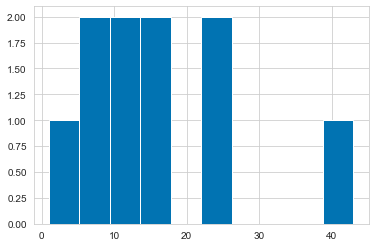

In [30]:
# посмотрим на гистограмма по участию в турнирах
rating_top_player.val_tournament.hist()
# в целом видно, что в топе люди, кто сыграл меньше 20 игр

7. Бонус: игроки со временем учатся играть лучше (а иногда бывает и наоборот). А в нашей модели получается, что первые неудачные турниры новичка будут тянуть его рейтинг вниз всю жизнь — это нехорошо, рейтинг должен быть достаточно гибким и иметь возможность меняться даже у игроков, отыгравших сотни турниров. Давайте попробуем этого добиться:
- если хватит вычислительных ресурсов, сначала сделайте baseline совсем без таких схем, обучив рейтинги на всех турнирах с повопросными результатами, а не только на турнирах 2019 года; улучшилось ли качество предсказаний на 2020?
- одну схему со временем мы уже использовали: брали для обучения только последний год турниров; примерно так делают, например, в теннисной чемпионской гонке; у этой схемы есть свои преимущества, но есть и недостатки (например, достаточно мало играть год, чтобы полностью пропасть из рейтинга);
- предложите варианты базовой модели или алгоритма её обучения, которые могли бы реализовать изменения рейтинга со временем; если получится, реализуйте их на практике, проверьте, улучшатся ли предсказания на 2020.

#### Обучение на всех данных

In [31]:
results_full, tournaments_full = data_selection(tournaments, results)

In [32]:
def train_test_split_full(results, tournaments):
    """Функция для train, test."""
    
    data_train, data_test = {}, {}
    
    for k, v in results.items():
        # формирование train
        if tournaments[k]["dateStart"][:4] != '2020':
            data_train[k] = {"tournament_name": tournaments[k]["name"]}
            res = []
            for turn in v:
                team_info = {"team_id": turn["team"]["id"], "mask": turn["mask"],
                             "position": turn["position"],
                             "teamMembers": [iterr["player"]["id"] for iterr in turn['teamMembers']]}
                res.append(team_info)
            data_train[k]["tournament_result"] = res
        else:
            # формирование test
            data_test[k] = {"tournament_name": tournaments[k]["name"]}
            res = []
            for turn in v:
                team_info = {"team_id": turn["team"]["id"], "mask": turn["mask"],
                             "position": turn["position"],
                             "teamMembers": [iterr["player"]["id"] for iterr in turn['teamMembers']]}
                res.append(team_info)
            data_test[k]["tournament_result"] = res
        
    return data_train, data_test

In [33]:
# формируем полную выборку для train и test
data_train_full, data_test_full = train_test_split_full(results_full, tournaments_full)

In [34]:
%%time

# фильтрация игроков
count_players_full = check_count_players(data_train_full)
filter_value_players_full = filter_value(count_players_full)
    
del_players_full = set()
for res in data_train_full.values():
    for tourn in res["tournament_result"]:
        tourn["teamMembers"] = set([-1 if iterr in filter_value_players_full else iterr for iterr in tourn["teamMembers"]])
        del_players_full.update(tourn["teamMembers"])

for res in data_test_full.values():
    for tourn in res["tournament_result"]:
        tourn["teamMembers"] = set([-1 if iterr not in del_players_full else iterr for iterr in tourn["teamMembers"]])  

Wall time: 1h 23min 54s


In [35]:
# обработка вопросов
questions_data_full = features_data(data_train_full)

In [36]:
# данные для обучения
X_train_full, y_train_full = data_to_split(data_train_full, questions_data_full, True)
# данные для теста
X_test_full, y_test_full = data_to_split(data_test_full, questions_data_full, False)

# обучаем baseline модель
model_full = linear_model.LogisticRegression()
model_full.fit(X_train_full, y_train_full)

# сделаем предикт на данных и выведем результаты по метрикам
pred_train_full = model_full.predict_proba(X_train_full)
pred_test_full = model_full.predict_proba(X_test_full)
print(f"Результаты для train на всем наборе: {log_loss(y_train_full, pred_train_full)}, результаты для test: {log_loss(y_test_full, pred_test_full)}")

Результаты для train на всем наборе: 0.5169154395489767, результаты для test: 0.7061593846469533


#### На полном наборе данных не много улучшилось качество предсказаний на 2020 год